In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, transpile
from functions_analysis import *


#Which time of the Trotter circuit do you want to plot (must be multiple of time step here dt=0.2)
initial_time=0.2 # initial Trotter step 
final_time=3.0 #final Trotter step

measurement='ZZZ'
randomized_compiling='crosstalk'

#list of the different observables (representing by the indices of qubits measured)
meas_list=[[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]

#number of twirls for Trotter circuits (up to 300)
nb_twirls=300

#number of twirls at different time steps for the estimation circuit
nb_twirls_list=[300,300,300,300,300,300,300,300,300,300,300,300,300,300,300]
#nb_twirls_list=[300,300,300,300,300,300,300,300,600,600,600,600,600,600,600]


In [2]:
#Variables to not change

backend = 'ibm_lagos'
nb_qubits=7


dt=0.2
initial_step=round(initial_time/dt)
final_step=round(final_time/dt)
nb_steps=final_step-initial_step+1
g=0.5
energies=[-1.,0,1.]
nb_shots=32000 #nb_shots used on the QC

nb_meas=len(meas_list)

if measurement=='ZZZ':
    title=['$Z_0$', '$Z_1$','$Z_2$','$Z_0 Z_1$','$Z_0 Z_2$','$Z_1 Z_2$','$Z_0 Z_1 Z_2$']
    
if measurement=='XYZ':
    title=['$X_0$', '$Y_1$','$Z_2$','$X_0 Y_1$','$X_0 Z_2$','$Y_1 Z_2$','$X_0 Y_1 Z_2$']
    
PATH_Trotter='/trotter_g='+str(g)+'_dt='+str(dt)+'_backend='+str(backend)+'.qasm'

PATH_estimation='/estimation_circuit/Quantum_Circuit/'+'estimation_'+randomized_compiling+'_twirl_g='+str(g)+'_dt='+str(dt)+'_backend='+str(backend)+'_0.qasm'



In [3]:
#Create the matrix measurement for readout error correction for the two type of protcols described in the article

meas_matrix=list(list(np.zeros([2,2]) for _ in range(nb_qubits)) for _ in range(nb_steps))
meas_matrix2=list(np.zeros([8,8]) for _ in range(nb_steps))

for t in range(initial_step,final_step+1):
    T=dt*t
    with open('data/'+measurement+'/T='+str(round(T,1))+'/measurement_'+randomized_compiling+'_twirl_g='+str(g)+
              '_dt='+str(dt)+'_backend='+str(backend)+'.json',"r") as json_file:
        results=json.load(json_file)
    
    #Protocol 1
    for i in range(nb_qubits):
        for j in range(2): 
            counts=results[2*i+j]
            if '0' in counts:
                meas_matrix[t-initial_step][i][0,j]=counts['0']/nb_shots
            if '1' in counts:
                meas_matrix[t-initial_step][i][1,j]=counts['1']/nb_shots
                
    #Protocol 2
    for k in range(8):
        counts=results[2*nb_qubits+k]
        for j1 in range(2):
            for j2 in range(2):
                for j3 in range(2):
                    j=j1*4+j2*2+j3
                    js=str(j1)+str(j2)+str(j3)
                    if js in counts:
                        meas_matrix2[t-initial_step][j,k]=counts[js]/nb_shots

In [4]:
# Creation of Trotter randomized compiling list for both protocols of readout error correction
trotter_rand=list(list(list(0. for _ in range(nb_twirls)) for _ in range(nb_steps)) for _ in range(nb_meas))
trotter_rand2=list(list(list(0. for _ in range(nb_twirls)) for _ in range(nb_steps)) for _ in range(nb_meas))

#Creation of Totter list for raw results
trotter_raw=list({} for _ in range(nb_steps))


for t in range(initial_step,final_step+1):
    if t//2*2!=t:
        lay=[0,2,1]
    else:
        lay=[0,1,2]
    T=dt*t  
    index=0
    for nb_job in range((nb_twirls-1)//300+1):
        #get the radnomized compiling Trotter results
        with open('data/'+measurement+'/T='+str(round(T,1))+'/randomized_compiling/data/results_trotter_'+
                  randomized_compiling+'_twirl_g='+str(g)+'_dt='+str(dt)+'_backend='+str(backend)+'_'+str(nb_job)+
                  '.json',"r") as json_file:
            results=json.load(json_file)
        
        #transform the dictionnary into a list
        data_list=list(0. for _ in range(8))
        for data_dict in results:
            for j1 in range(2):
                for j2 in range(2):
                    for j3 in range(2):
                        j=j1*4+j2*2+j3
                        js=str(j1)+str(j2)+str(j3)
                        if js in data_dict:
                            data_list[j]=data_dict[js]/nb_shots
                            
            #Mitigate the data with the inverse bayesian unfolding (IBU function defined in functions_analysis.py)
            
            #Protocol 1
            data_mitig=IBU(data_list,np.ones(8),np.kron(np.eye(4),meas_matrix[t-initial_step][0]),10)
            data_mitig2=IBU(data_mitig,np.ones(8),np.kron(np.kron(np.eye(2),meas_matrix[t-initial_step][1]),np.eye(2)),10)
            data_mitig3=IBU(data_mitig2,np.ones(8),np.kron(meas_matrix[t-initial_step][2],np.eye(4)),10)
            
            #Protocol 2
            data_mitig4=IBU(data_list,np.ones(8),meas_matrix2[t-initial_step],10)
            
            #Compute the 7 different corresponding observables
            for obs in range(len(meas_list)):
                m=list(lay[meas] for meas in meas_list[obs])
                for k in range(8):   
                    trotter_rand[obs][t-initial_step][index]+=(-1)**(sum(k//2**m[i] for i in range(len(m))))*data_mitig3[k]
                    trotter_rand2[obs][t-initial_step][index]+=(-1)**(sum(k//2**m[i] for i in range(len(m))))*data_mitig4[k]
            index+=1
    
    #Get the Trotter raw results
    with open('data/'+measurement+'/T='+str(round(T,1))+'/raw_results_Trotter_run='+randomized_compiling+
              '_twirl_g='+str(g)+'_dt='+str(dt)+'_backend='+str(backend)+'.json','r') as json_file:
        trotter_raw[t-initial_step] = json.load(json_file)
    
#Get the simulation on perfect QC    
with open('data/'+measurement+'/results_simulation_Trotter_perfect.json','r') as json_file:
    trotter_sim = json.load(json_file)


trot_sim=list(list(0. for _ in range(nb_steps)) for _ in range(nb_meas))
trot_qc=list(list(0. for _ in range(nb_steps)) for _ in range(nb_meas))

for i in range(nb_steps):
    
    #Convert dictonnary counts in list
    data_dict_qc=trotter_raw[i]
    data_dict_sim=trotter_sim[i]
    data_list_qc=list(0 for _ in range(8))
    data_list_sim=list(0 for _ in range(8))
    for j1 in range(2):
        for j2 in range(2):
            for j3 in range(2):
                j=j1*4+j2*2+j3
                js=str(j1)+str(j2)+str(j3)
                if js in data_dict_sim:
                    data_list_sim[j]=data_dict_sim[js]/nb_shots
                if js in data_dict_qc:
                    data_list_qc[j]=data_dict_qc[js]/nb_shots
                    
    #Compute the 7 different corresponding observables               
    t=initial_step+i
    if t//2*2!=t:
        lay=[0,2,1]
    else:
        lay=[0,1,2]
    for obs in range(len(meas_list)):
        m=list(lay[meas] for meas in meas_list[obs])
        for k in range(8): 
            trot_sim[obs][i]+=(-1)**(sum(k//2**m[i] for i in range(len(m))))*data_list_sim[k]
            trot_qc[obs][i]+=(-1)**(sum(k//2**m[i] for i in range(len(m))))*data_list_qc[k]

In [5]:
#Mean value of Trotter randomized compiling
mean_trotter=list(list(0 for _ in range(nb_steps)) for _ in range(nb_meas))
mean_trotter2=list(list(0 for _ in range(nb_steps)) for _ in range(nb_meas))
for obs in range(nb_meas):
    for t in range(nb_steps):
        mean_trotter[obs][t]=np.mean(trotter_rand[obs][t])
        mean_trotter2[obs][t]=np.mean(trotter_rand2[obs][t])

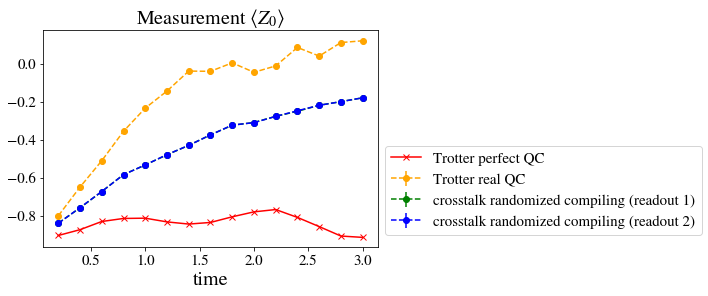

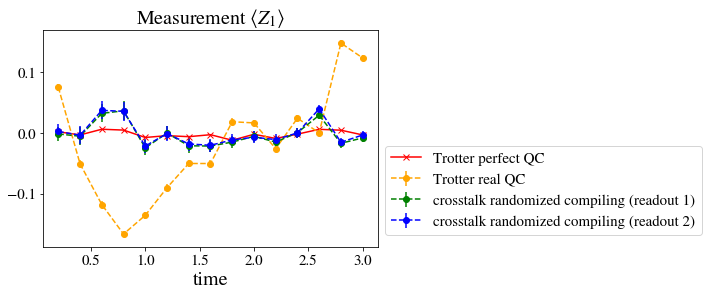

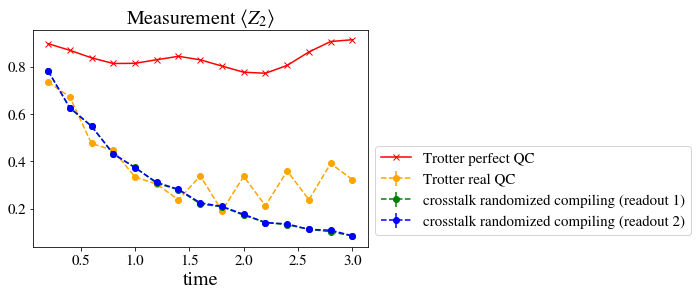

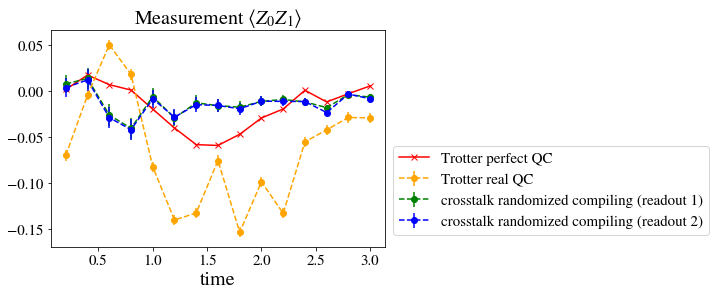

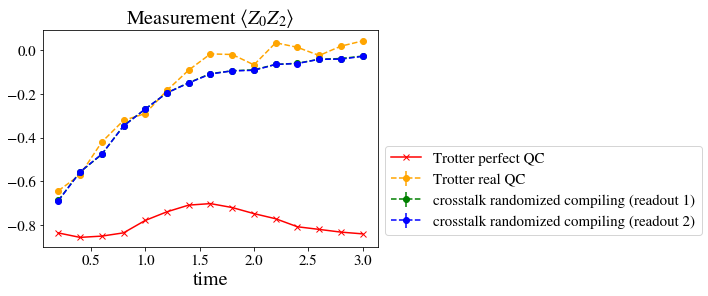

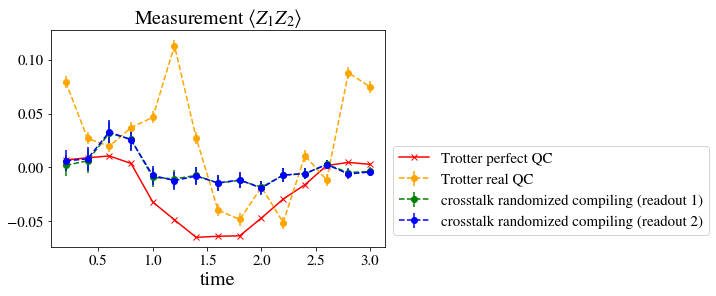

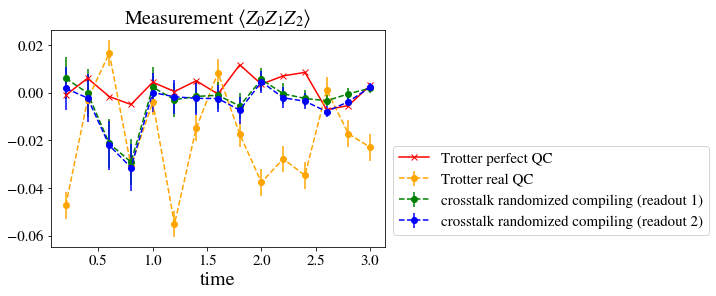

In [6]:
time_list=list(i*dt for i in range(initial_step,final_step+1))

#error bars
std_raw=list(list(np.sqrt(1-trot_qc[obs][t]**2)/np.sqrt(nb_shots) 
                  for t in range(nb_steps)) for obs in range(nb_meas))
var_shot_trot=list(list(list(1-trotter_rand[obs][t][i]**2 
                             for i in range(nb_twirls)) for t in range(nb_steps)) for obs in range(nb_meas)) 
shot_noise_trot=list(list(np.mean(var_shot_trot[obs][t])/(nb_twirls*nb_shots) 
                          for t in range(nb_steps)) for obs in range(nb_meas)) 
var_shot_trot2=list(list(list(1-trotter_rand2[obs][t][i]**2 for i in range(nb_twirls)) 
                         for t in range(nb_steps)) for obs in range(nb_meas)) 
shot_noise_trot2=list(list(np.mean(var_shot_trot2[obs][t])/(nb_twirls*nb_shots) 
                           for t in range(nb_steps)) for obs in range(nb_meas)) 
std_twirl=list(list(np.sqrt(np.var(trotter_rand[obs][t], ddof=1)/nb_twirls+shot_noise_trot[obs][t]) 
                    for t in range(nb_steps)) for obs in range(nb_meas))
std_twirl2=list(list(np.sqrt(np.var(trotter_rand2[obs][t], ddof=1)/nb_twirls+shot_noise_trot2[obs][t])
                    for t in range(nb_steps)) for obs in range(nb_meas))

plt.rcParams['font.size'] = 15
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

for obs in range (nb_meas):
    plt.plot(time_list,trot_sim[obs],'-x', color='red',label='Trotter perfect QC')
    plt.errorbar(time_list,trot_qc[obs],fmt='--o',yerr=std_raw[obs], color='orange',label='Trotter real QC')
    plt.errorbar(time_list,mean_trotter[obs],fmt='--o', yerr=std_twirl[obs], color='green',label=randomized_compiling+' randomized compiling (readout 1)')
    plt.errorbar(time_list,mean_trotter2[obs],fmt='--o',yerr=std_twirl2[obs], color='blue',label=randomized_compiling+' randomized compiling (readout 2)')
    plt.xlabel('time',fontsize=20)
    
    plt.title(label=r'Measurement $\langle$'+title[obs]+r'$\rangle$',fontsize=20)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()


In [7]:
#Fit the results of QC with the noise model
from scipy import optimize
fit1_trotter=optimize.least_squares(fit_trotter,[0.01,0.01,0.001,0.001,0.001], 
                                    args=(mean_trotter,initial_step, final_step,meas_list,measurement,dt,PATH_Trotter),
                                          method='trf', bounds=[[0,0,0,0,0],[16/15,16/15,4/3,4/3,64/63]])

#parameters of the fits defined on Qiskit do not correspond to the one in the article (see functions_analysis.py)
print('fitting parameters for protocol 1: '+ str(fit1_trotter.x))

print('fitting parameters for protocol 1 mapped to the definition of the article: '+ str(transf_noise_params(fit1_trotter.x)))

fit2_trotter=optimize.least_squares(fit_trotter,[0.01,0.01,0.001,0.001,0.001], 
                                    args=(mean_trotter2,initial_step, final_step,meas_list,measurement,dt,PATH_Trotter),
                                          method='trf', bounds=[[0,0,0,0,0],[16/15,16/15,4/3,4/3,64/63]])
print('fitting parameters for protocol 2: '+ str(fit2_trotter.x))

print('fitting parameters for protocol 2 mapped to the definition of the article: '+ str(transf_noise_params(fit2_trotter.x)))


fitting parameters for protocol 1: [1.23272441e-02 9.77879840e-03 3.48248547e-02 6.97334963e-03
 1.23323470e-15]
fitting parameters for protocol 1 mapped to the definition of the article: [0.011897949599933675, 0.009710607418811362, 0.034395560195491115, 0.006905158645544271, 0.0002286814262264822]
fitting parameters for protocol 2: [1.26473669e-02 6.41036387e-03 4.18124362e-02 6.77008608e-03
 3.74329604e-15]
fitting parameters for protocol 2 mapped to the definition of the article: [0.012118549658027397, 0.006366965157846246, 0.041283618981626115, 0.006726687362302207, 0.0002591402732293815]


regression standard error=0.00020155811199814634


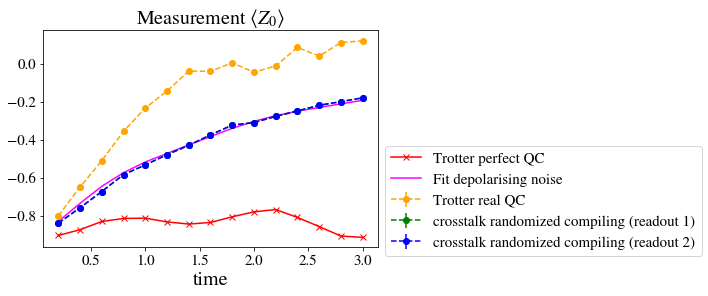

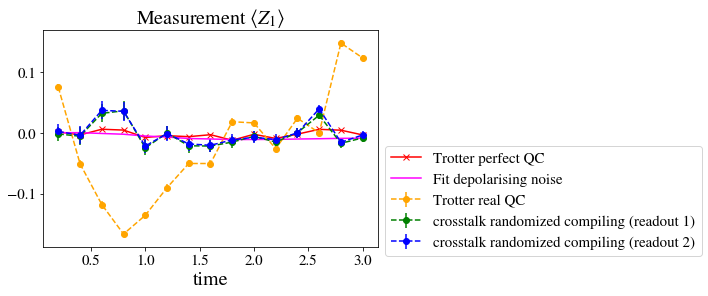

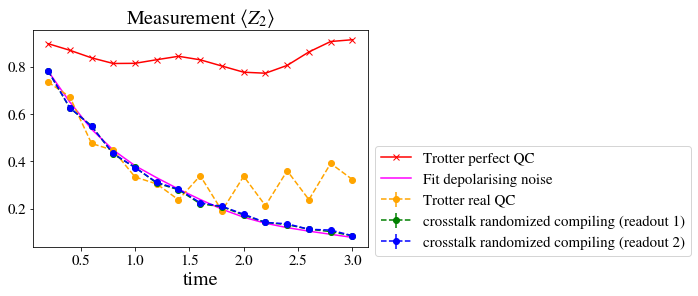

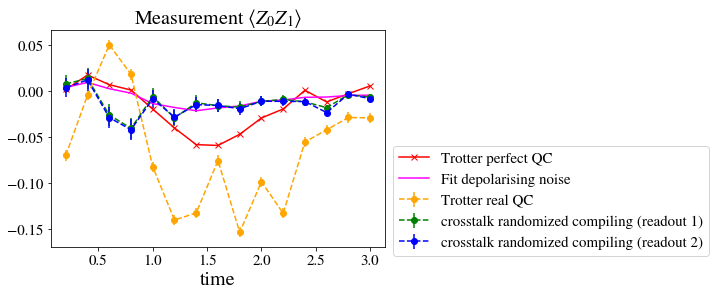

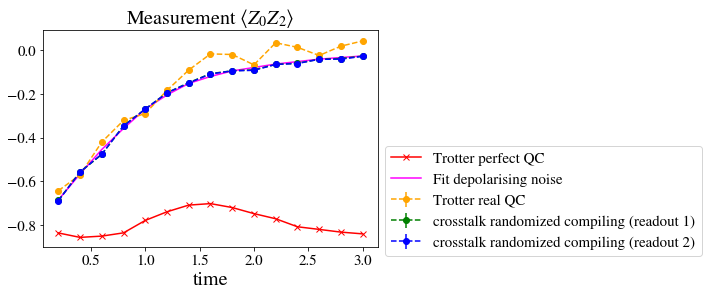

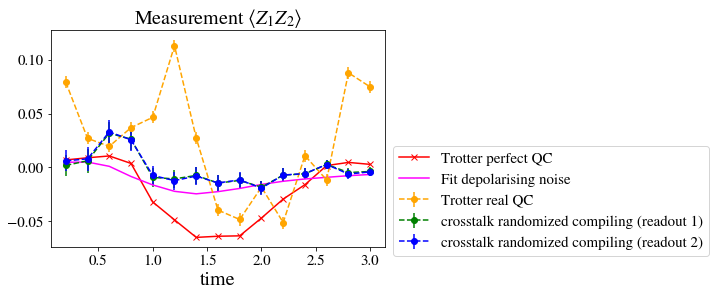

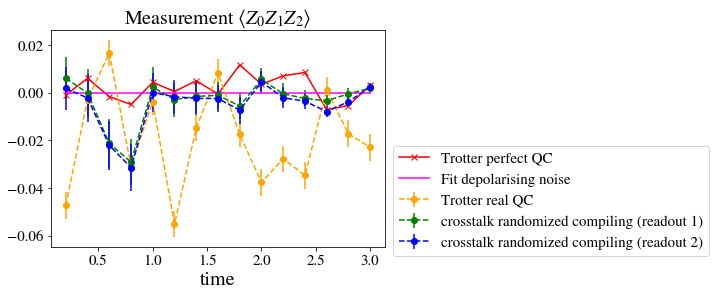

In [8]:
#Plot results of QC with fits

#errors=fit2_trotter.x #get the results for protocol 2 from the above cell
errors=[1.26473669e-02, 6.41036387e-03, 4.18124362e-02, 6.77008608e-03,3.74329604e-15] #to avoid running the above cell 
        #each time the notebook is opened, here it is the result of the fit for the protocol 2 
        #for the whole evolution 0.2<=t <=3.0

trotter_noise=noisy_trotter(errors,initial_step,final_step,meas_list,measurement,dt,PATH_Trotter)
regression=(np.linalg.norm(fit_trotter(errors,mean_trotter2,initial_step,final_step,meas_list,measurement,dt,PATH_Trotter)))**2/((len(meas_list)*nb_steps-5))
print('regression standard error='+str(regression))
time_list=list(i*dt for i in range(initial_step,final_step+1))

plt.rcParams['font.size'] = 15
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

for obs in range(nb_meas):
    plt.plot(time_list,trot_sim[obs],'-x', color='red',label='Trotter perfect QC')
    plt.errorbar(time_list,trot_qc[obs],fmt='--o',yerr=std_raw[obs], color='orange',label='Trotter real QC')
    plt.errorbar(time_list,mean_trotter[obs],fmt='--o', yerr=std_twirl[obs], color='green',label=randomized_compiling+' randomized compiling (readout 1)')
    plt.errorbar(time_list,mean_trotter2[obs],fmt='--o',yerr=std_twirl2[obs], color='blue',label=randomized_compiling+' randomized compiling (readout 2)')
    plt.plot(time_list,trotter_noise[obs],'-', color='magenta',label='Fit depolarising noise')
    plt.xlabel('time',fontsize=20)
    
    plt.title(label=r'Measurement $\langle$'+title[obs]+r'$\rangle$',fontsize=20)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()


In [9]:
#Noise estimation circuit

noise_estimation=list(list(list(0. for _ in range(nb_twirls_list[t+initial_step-1])) 
                           for t in range(nb_steps)) for _ in range(nb_meas))
mean_estimation=list(list(0. for _ in range(nb_steps)) for _ in range(nb_meas))

noise_estimation2=list(list(list(0. for _ in range(nb_twirls_list[t+initial_step-1])) for t in range(nb_steps)) for _ in range(nb_meas))
mean_estimation2=list(list(0. for _ in range(nb_steps)) for _ in range(nb_meas))

for t in range(initial_step,final_step+1):
    if t//2*2!=t:
        lay=[0,2,1]
    else:
        lay=[0,1,2]
    T=dt*t  
    index=0
    for nb_job in range((nb_twirls_list[t-initial_step]-1)//300+1):
        #get the noise estimation results
        with open('data/'+measurement+'/T='+str(round(T,1))+'/estimation_circuit/data/results_estimation_'+
                  randomized_compiling+'_twirl_g='+str(g)+'_dt='+str(dt)+'_backend='+str(backend)+'_'+str(nb_job)+
                  '.json',"r") as json_file:
            results=json.load(json_file)
        
        #transform the dictionnary into a list
        data_list=list(0. for _ in range(8))
        for data_dict in results:
            for j1 in range(2):
                for j2 in range(2):
                    for j3 in range(2):
                        j=j1*4+j2*2+j3
                        js=str(j1)+str(j2)+str(j3)
                        if js in data_dict:
                            data_list[j]=data_dict[js]/nb_shots
                            
            #Mitigate the data with the inverse bayesian unfolding (IBU function defined in functions_analysis.py)
            
            #Protocol 1
            data_mitig=IBU(data_list,np.ones(8),np.kron(np.eye(4),meas_matrix[t-initial_step][0]),10)
            data_mitig2=IBU(data_mitig,np.ones(8),np.kron(np.kron(np.eye(2),meas_matrix[t-initial_step][1]),np.eye(2)),10)
            data_mitig3=IBU(data_mitig2,np.ones(8),np.kron(meas_matrix[t-initial_step][2],np.eye(4)),10)
            
            #Protocol 2
            data_mitig4=IBU(data_list,np.ones(8),meas_matrix2[t-initial_step],10)
            
            #Compute the 7 different corresponding observables
            for obs in range(len(meas_list)):
                m=list(lay[meas] for meas in meas_list[obs])
                for k in range(8):   
                    noise_estimation[obs][t-initial_step][index]+=(-1)**(sum(k//2**m[i] for i in range(len(m))))*data_mitig3[k]
                    noise_estimation2[obs][t-initial_step][index]+=(-1)**(sum(k//2**m[i] for i in range(len(m))))*data_mitig4[k]
            index+=1
    for obs in range(nb_meas):
        mean_estimation[obs][t-initial_step]=np.mean(noise_estimation[obs][t-initial_step])
        mean_estimation2[obs][t-initial_step]=np.mean(noise_estimation2[obs][t-initial_step])       
    
  

In [10]:
#Fit estimation circuit results
from scipy import optimize
fit1_est=optimize.least_squares(fit_estimation,[0.01,0.01,0.001,0.001,0.001], 
                                    args=(mean_estimation,initial_step, final_step,meas_list,dt,PATH_estimation),
                                          method='trf', bounds=[[0,0,0,0,0],[16/15,16/15,4/3,4/3,64/63]])

print('fitting parameters for protocol 1: '+ str(fit1_est.x))

print('fitting parameters for protocol 1 mapped to the definition of the article: '+ str(transf_noise_params(fit1_est.x)))


fit2_est=optimize.least_squares(fit_estimation,[0.01,0.01,0.001,0.001,0.001], 
                                    args=(mean_estimation2,initial_step, final_step,meas_list,dt,PATH_estimation),
                                          method='trf', bounds=[[0,0,0,0,0],[16/15,16/15,4/3,4/3,64/63]])

print('fitting parameters for protocol 2: '+ str(fit2_est.x))

print('fitting parameters for protocol 2 mapped to the definition of the article: '+ str(transf_noise_params(fit2_est.x)))


fitting parameters for protocol 1: [0.00804035 0.00899958 0.04090312 0.00891891 0.00137639]
fitting parameters for protocol 1 mapped to the definition of the article: [0.0077008573034255505, 0.008907032963632256, 0.040518397072383236, 0.0088264758845564, 0.0015668898504900806]
fitting parameters for protocol 2: [0.0072016  0.00868124 0.04223159 0.009779   0.00132452]
fitting parameters for protocol 2 mapped to the definition of the article: [0.006888331093977867, 0.008584956489930745, 0.041871919645073544, 0.009681263342889464, 0.0015066165273644066]


regression standard error=0.0004357968411246138


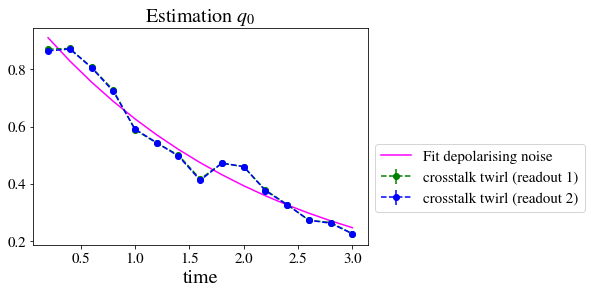

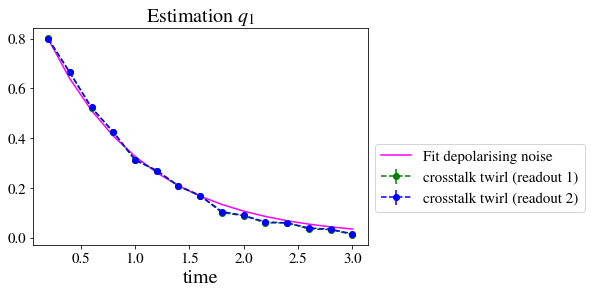

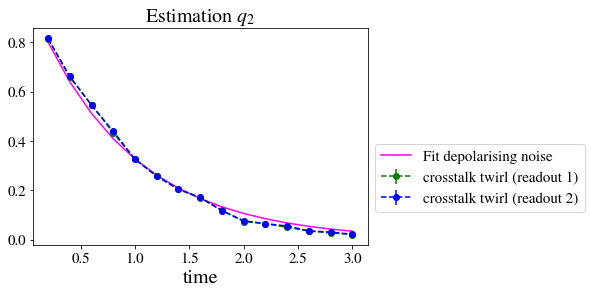

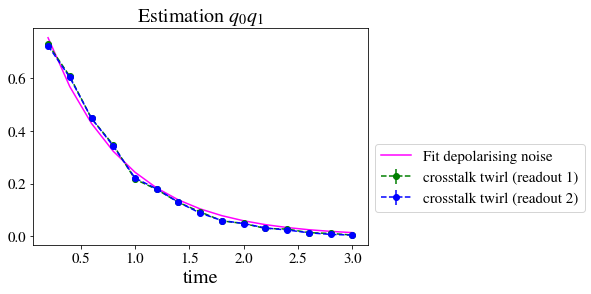

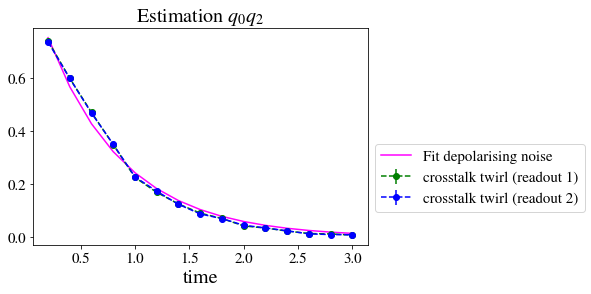

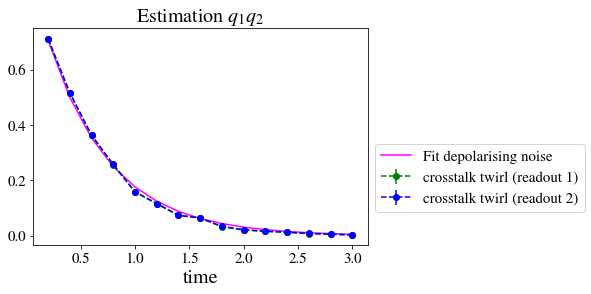

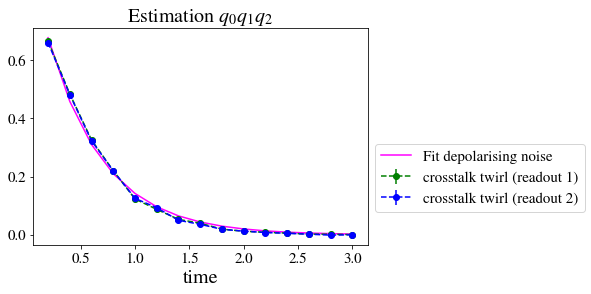

In [13]:
#Plot noise estimation circuit results 

#errors_est=fit2_est.x #get the results for protocol 2 from the above cell
errors_est=[0.00779429, 0.01615566, 0.05241134, 0.00859784, 0.00210066]#to avoid running the above cell
          #each time the notebook is opened, here it is the result of the fit for the protocol 2
           #for the whole evolution 0.2<=t <=3.0 and 300 noise estimation circuits at every time steps


estimation_noise=noisy_estimation_circuit(errors_est,initial_step,final_step,meas_list,dt,PATH_estimation)
regression=np.linalg.norm(fit_estimation(errors_est,mean_estimation2,initial_step,final_step,meas_list,dt,PATH_estimation))**2/(len(meas_list)*nb_steps-5)
print('regression standard error='+str(regression))

title_estimation=['$q_0$','$q_1$','$q_2$','$q_0 q_1$','$q_0q_2$','$q_1q_2$','$q_0q_1q_2$']

#error bars
var_shot_est=list(list(list(1-noise_estimation[obs][t][i]**2 
                            for i in range(nb_twirls_list[t+initial_step-1])) for t in range(nb_steps)) for obs in range(nb_meas)) 
shot_noise_est=list(list(np.mean(var_shot_est[obs][t])/(nb_twirls_list[t+initial_step-1]*nb_shots) 
                         for t in range(nb_steps)) for obs in range(nb_meas)) 
var_shot_est2=list(list(list(1-noise_estimation2[obs][t][i]**2 
                             for i in range(nb_twirls_list[t+initial_step-1])) for t in range(nb_steps)) for obs in range(nb_meas)) 
shot_noise_est2=list(list(np.mean(var_shot_est2[obs][t])/(nb_twirls_list[t+initial_step-1]*nb_shots) 
                          for t in range(nb_steps)) for obs in range(nb_meas)) 


std_estimation=list(list(np.sqrt(np.var(noise_estimation[obs][t], ddof=1)/nb_twirls_list[t+initial_step-1]+shot_noise_est[obs][t])
                         for t in range(nb_steps)) for obs in range(nb_meas))
std_estimation2=list(list(np.sqrt(np.var(noise_estimation2[obs][t], ddof=1)/nb_twirls_list[t+initial_step-1]+shot_noise_est2[obs][t]) 
                          for t in range(nb_steps)) for obs in range(nb_meas))

time_list=list(i*dt for i in range(initial_step,final_step+1))
plt.rcParams['font.size'] = 15
for obs in range(nb_meas):
    plt.errorbar(time_list,mean_estimation[obs],fmt='--o', yerr=std_estimation[obs], color='green',label=randomized_compiling+' RC (readout 1)')
    plt.errorbar(time_list,mean_estimation2[obs],fmt='--o', yerr=std_estimation2[obs], color='blue',label=randomized_compiling+' RC (readout 2)')
    plt.plot(time_list,estimation_noise[obs],'-', color='magenta',label='Fit depolarising noise')
    plt.xlabel('time',fontsize=20)
    
    plt.title(label=r'Estimation '+title_estimation[obs],fontsize=20)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()


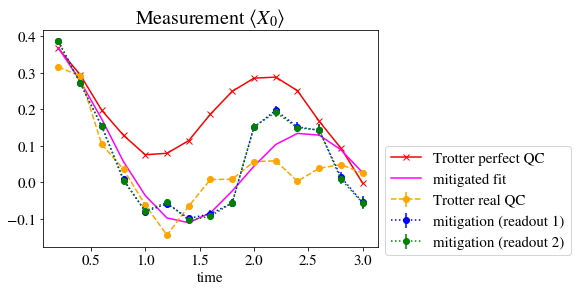

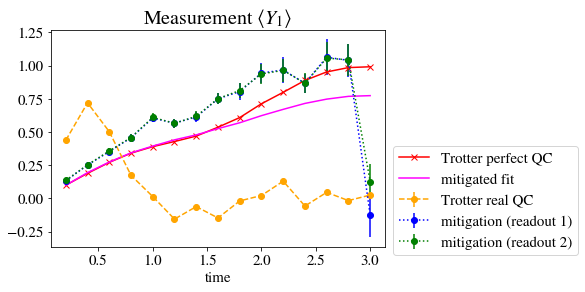

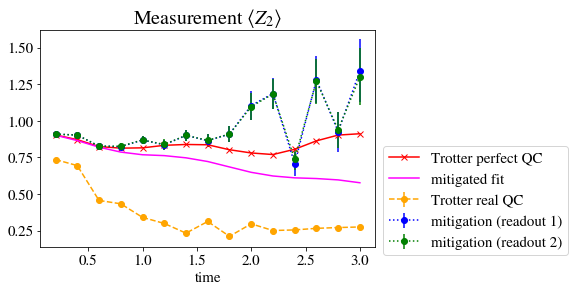

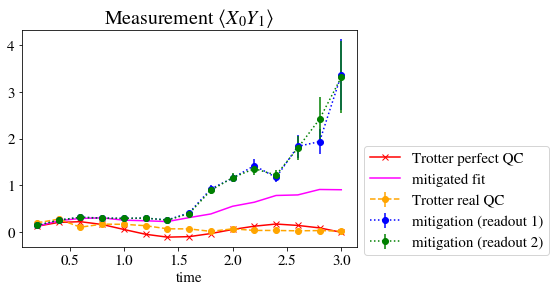

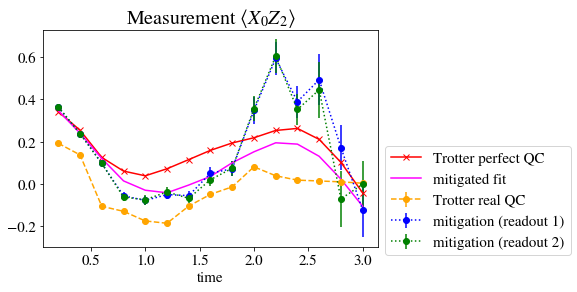

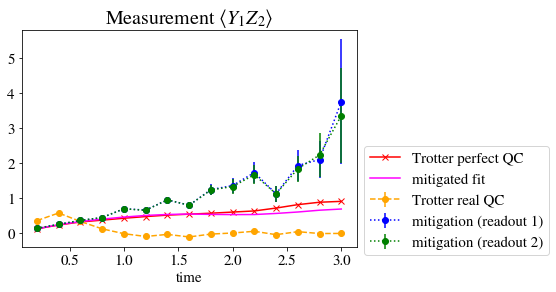

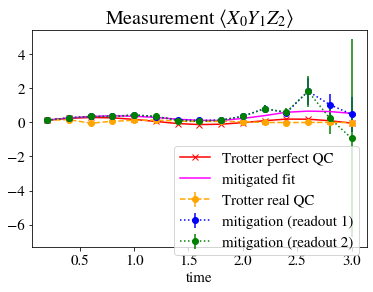

In [14]:
#Plot mitigated results of the QC and the one obtained by simulation of noise model 
#using the parameters derived from the fit of the Trotter results

estimation_noise_bis=noisy_estimation_circuit(errors,initial_step,final_step,meas_list,dt,PATH_estimation)
mitigation_noise=list(list(trotter_noise[obs][t]/estimation_noise_bis[obs][t] for t in range(nb_steps)) for obs in range(nb_meas))

mean_mit=list(list(0 for _ in range(nb_steps)) for _ in range(nb_meas))
mean_mit2=list(list(0 for _ in range(nb_steps)) for _ in range(nb_meas))
for obs in range(nb_meas):
    for t in range(nb_steps):
        mean_mit[obs][t]=mean_trotter[obs][t]/mean_estimation[obs][t]
        mean_mit2[obs][t]=mean_trotter2[obs][t]/mean_estimation2[obs][t]

#error bars
noise_sampling=list(list(np.sqrt(mean_trotter[obs][t]**2*std_estimation[obs][t]**2+ mean_estimation[obs][t]**2*std_twirl[obs][t]**2)/mean_estimation[obs][t]**2 for t in range(nb_steps)) for obs in range(nb_meas))
noise_sampling2=list(list(np.sqrt(mean_trotter2[obs][t]**2*std_estimation2[obs][t]**2+ mean_estimation2[obs][t]**2*std_twirl2[obs][t]**2)/mean_estimation2[obs][t]**2 for t in range(nb_steps)) for obs in range(nb_meas))

plt.rcParams['font.size'] = 15   
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
time_list=list(i*dt for i in range(initial_step,final_step+1))
for obs in range (nb_meas):
    plt.plot(time_list,trot_sim[obs],'-x', color='red',label='Trotter perfect QC')
    plt.errorbar(time_list,trot_qc[obs],fmt='--o',yerr=std_raw[obs], color='orange',label='Trotter real QC')
    plt.errorbar(time_list,mean_mit[obs],fmt=':o',yerr=noise_sampling[obs], color='b',label='mitigation (readout 1)')
    plt.errorbar(time_list,mean_mit2[obs],fmt=':o',yerr=noise_sampling2[obs], color='g',label='mitigation (readout 2)')
    plt.plot(time_list,mitigation_noise[obs],'-', color='magenta',label='mitigated fit')
    
    plt.xlabel('time')

    #plt.ylim(0.,1)
    
    plt.title(label=r'Measurement $\langle$'+title[obs]+r'$\rangle$',fontsize=20)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()
